In [1]:
import os, sys, warnings, time, memory_profiler
import numpy as np, matplotlib.pyplot as plt
from sequentia import *
from tqdm.auto import tqdm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Flatten

# Silence TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Import utility functions and classes
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils import *
from nn import NNClassifier

# Filter warnings
warnings.filterwarnings('ignore')

# ggplot style
plt.style.use('ggplot')

# Set seed for reproducible randomness
seed = 0
np.random.seed(seed)
rng = np.random.RandomState(seed=seed)

In [2]:
gestures_map = {
    'nd': 'nod',
    'mnd': 'multiple nods',
    'fu': 'face-up',
    'fd': 'face-down',
    'sh': 'shake',
    't': 'turn',
    'ti': 'tilt'
}

gestures = list(gestures_map.keys())

In [3]:
fields = ['Rx', 'Ry', 'Rz']

In [4]:
# Containers to store classifiers and results
clfs, results = {}, {'hmm': {}, 'knn': {}, 'ffnn': {}, 'lstm': {}}

In [5]:
# Load the MoCap dataset
loader = MoCapLoader(normalized=False)
X, y = loader.load(fields)

## Dataset splits

Create a stratified 65-20-15 training, validation and test set split.

In [6]:
# Create a stratified training, validation and test set split (65-20-15)
X_train, X_val, X_test, y_train, y_val, y_test = data_split(X, y, (65, 20, 15), random_state=rng, stratify=True)

Training set size: 841
Validation set size: 259
Test set size: 195


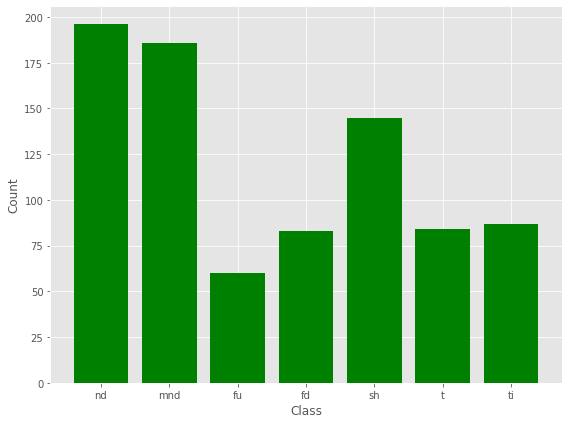

In [7]:
# MoCap dataset class counts (training set)
show_class_counts(y_train, gestures, title=None)

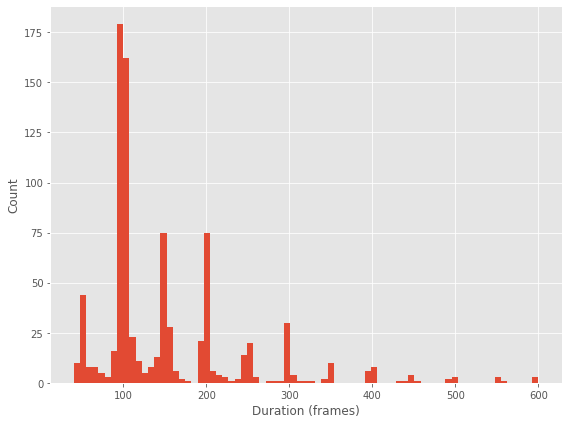

In [8]:
# Histogram of MoCap dataset gesture durations (training set)
show_durations(X_train, bins=75, title=None)

## Preprocessing

In [9]:
# Create a preprocessing pipeline
pre = Preprocess([
    Filter(window_size=10, method='median'),
    BinDownsample(bin_size=50, method='decimate'),
    Center()
])
pre.summary()

             Preprocessing summary:            
1. Filter
   Median filtering with window-size 10
-----------------------------------------------
2. BinDownsample
   Decimation bin-downsampling with bin-size 50
-----------------------------------------------
3. Center
   Centering around mean (zero mean)


In [10]:
# Function for visualizing gesture signals
def plot_gesture(gesture, label, figsize=(7, 5), same_scale=True):
    labels = ['$\\varphi^{(t)}_x$', '$\\varphi^{(t)}_y$', '$\\varphi^{(t)}_z$']
    colors = ['blue', 'red', 'green']
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=figsize)
    
    for i, ax in enumerate(axs.flat):
        ax.plot(gesture[:, i], color=colors[i])
        ax.set_ylabel(labels[i], rotation=0, labelpad=7, fontsize=14)
        if same_scale:
            pad = 0.05
            ax.set_ylim(gesture.min()-pad, gesture.max()+pad)
    ax.set_xlabel('Duration (frames)')
        
    fig.tight_layout()
#     plt.savefig('plots/example-rotation-signal.pdf')
    plt.show()

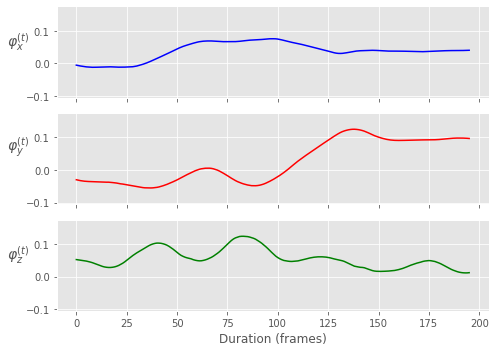

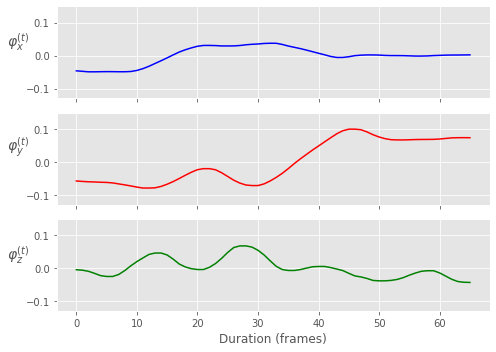

In [11]:
# Pick an example signal for visualization
x_sample, y_sample = X_train[1], y_train[1]
plot_gesture(x_sample, y_sample)
plot_gesture(pre.transform(x_sample), y_sample)

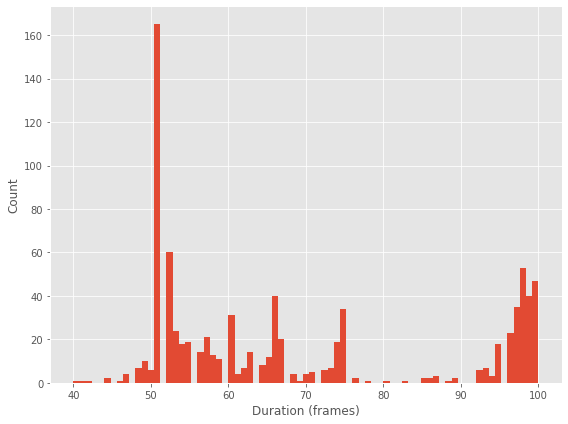

In [12]:
# Transform training data and plot histogram of MoCap dataset gesture durations (training set)
Xp_train = pre.fit_transform(X_train, verbose=True)
show_durations(Xp_train, bins=75, title=None)

In [13]:
# Apply the preprocessing pipeline to the other dataset splits
Xp_val, Xp_test = pre.transform(X_val, verbose=True), pre.transform(X_test, verbose=True)

## DTWKNN classifier

### Fitting the model

### Evaluating the model

## Hidden Markov Model classifier

One gesture model $\lambda_i=(A_i,B_i,\pi_i)$ is initialized and trained for each of the gestures: `nd`, `mnd`, `sh`, `fd`, `t`, `ti`, `fu`.

### Training the model

### Evaluating the model

## Feedforward Neural Network classifier

### Fitting the model

### Evaluating the model

## LSTM classifier

### Fitting the model

### Evaluating the model

# Hyper-parameter searches

## HMM

## DTWKNN

### Radius parameter

### Neighborhood parameter ($k$)

## FFNN

## LSTM

# Test results

## DTWKNN

## HMM

## FFNN

## LSTM

In [14]:
epochs = None

for repeat in range(5):
    seed = repeat
    np.random.seed(seed)
    rng = np.random.RandomState(seed=seed)
    
    X_train, X_val, X_test, y_train, y_val, y_test = data_split(X, y, (65, 20, 15), random_state=rng, stratify=True)
    Xp_train = pre.fit_transform(X_train, verbose=True)
    Xp_val, Xp_test = pre.transform(X_val, verbose=True), pre.transform(X_test, verbose=True)

    clf = None
    running_stats = {'fit': {}, 'predict': {}}

    def fit():
        e = 500 if epochs is None else epochs
        clf = NNClassifier(epochs=e, batch_size=128, optimizer=Adam(learning_rate=0.002), classes=gestures)
                
        arch = [
            Bidirectional(LSTM(300, return_sequences=True, recurrent_dropout=0.5)),
            Bidirectional(LSTM(300, recurrent_dropout=0.5)),
            Dense(100, activation='relu'),
            Dense(len(gestures), activation='softmax')
        ]

        if epochs is None:
            hist = clf.fit(arch, Xp_train, y_train, validation_data=(Xp_val, y_val), return_history=True, verbose=2, patience=40)
        else:
            hist = clf.fit(arch, Xp_train, y_train, validation_data=(Xp_val, y_val), return_history=True, verbose=2, early_stop=False)
        return clf, hist

    t0 = time.time()
    mem, out = memory_profiler.memory_usage(fit, retval=True)
    clf, hist = out
    running_stats['fit']['memory'] = max(mem)
    running_stats['fit']['time'] = time.time() - t0
    
    if epochs is None:
        epochs = len(hist.history['loss'])

    def evaluate():
        return clf.evaluate(Xp_test, y_test)

    t0 = time.time()
    mem, res = memory_profiler.memory_usage(evaluate, retval=True)
    running_stats['predict']['memory'] = max(mem)
    running_stats['predict']['time'] = time.time() - t0
    results['lstm']['test'] = res

    # Write the results
    write_network_results('lstm', results, hist, running_stats, 'final', 'test', number=repeat, save_history=True, save_cm=True)

Training set size: 841
Validation set size: 259
Test set size: 195



Train on 841 samples, validate on 259 samples
Epoch 1/500
841/841 [==============================] - 26s 31ms/sample - loss: 1.9247 - accuracy: 0.2128 - val_loss: 1.8386 - val_accuracy: 0.3127
Epoch 2/500
841/841 [==============================] - 15s 18ms/sample - loss: 1.8236 - accuracy: 0.2390 - val_loss: 1.7011 - val_accuracy: 0.3243
Epoch 3/500
841/841 [==============================] - 15s 17ms/sample - loss: 1.7509 - accuracy: 0.2830 - val_loss: 1.6530 - val_accuracy: 0.3320
Epoch 4/500
841/841 [==============================] - 15s 17ms/sample - loss: 1.7121 - accuracy: 0.3032 - val_loss: 1.6305 - val_accuracy: 0.3089
Epoch 5/500
841/841 [==============================] - 15s 18ms/sample - loss: 1.6617 - accuracy: 0.3175 - val_loss: 1.6288 - val_accuracy: 0.3436
Epoch 6/500
841/841 [==============================] - 14s 17ms/sample - loss: 1.6581 - accuracy: 0.3210 - val_loss: 1.5839 - val_accuracy: 0.3784
Epoch 7/500
841/841 [==============================] - 15s 18ms/sample 


Train on 841 samples, validate on 259 samples
Epoch 1/117
841/841 [==============================] - 23s 27ms/sample - loss: 1.8905 - accuracy: 0.2152 - val_loss: 1.8291 - val_accuracy: 0.2625
Epoch 2/117
841/841 [==============================] - 14s 16ms/sample - loss: 1.7890 - accuracy: 0.2913 - val_loss: 1.6822 - val_accuracy: 0.3320
Epoch 3/117
841/841 [==============================] - 15s 18ms/sample - loss: 1.7175 - accuracy: 0.3115 - val_loss: 1.6542 - val_accuracy: 0.3089
Epoch 4/117
841/841 [==============================] - 14s 17ms/sample - loss: 1.6508 - accuracy: 0.3222 - val_loss: 1.6282 - val_accuracy: 0.3475
Epoch 5/117
841/841 [==============================] - 13s 15ms/sample - loss: 1.5952 - accuracy: 0.3603 - val_loss: 1.6770 - val_accuracy: 0.3166
Epoch 6/117
841/841 [==============================] - 13s 15ms/sample - loss: 1.6002 - accuracy: 0.3306 - val_loss: 1.6136 - val_accuracy: 0.3707
Epoch 7/117
841/841 [==============================] - 14s 17ms/sample 


Train on 841 samples, validate on 259 samples
Epoch 1/117
841/841 [==============================] - 22s 27ms/sample - loss: 1.8911 - accuracy: 0.2152 - val_loss: 1.8335 - val_accuracy: 0.2780
Epoch 2/117
841/841 [==============================] - 14s 17ms/sample - loss: 1.7982 - accuracy: 0.2711 - val_loss: 1.6988 - val_accuracy: 0.3089
Epoch 3/117
841/841 [==============================] - 14s 17ms/sample - loss: 1.7162 - accuracy: 0.2913 - val_loss: 1.6367 - val_accuracy: 0.3475
Epoch 4/117
841/841 [==============================] - 13s 16ms/sample - loss: 1.6731 - accuracy: 0.3187 - val_loss: 1.6550 - val_accuracy: 0.3320
Epoch 5/117
841/841 [==============================] - 17s 20ms/sample - loss: 1.6512 - accuracy: 0.3258 - val_loss: 1.6358 - val_accuracy: 0.3629
Epoch 6/117
841/841 [==============================] - 13s 16ms/sample - loss: 1.6161 - accuracy: 0.3294 - val_loss: 1.6010 - val_accuracy: 0.3127
Epoch 7/117
841/841 [==============================] - 14s 16ms/sample 


Train on 841 samples, validate on 259 samples
Epoch 1/117
841/841 [==============================] - 22s 27ms/sample - loss: 1.9478 - accuracy: 0.1950 - val_loss: 1.8646 - val_accuracy: 0.2973
Epoch 2/117
841/841 [==============================] - 13s 16ms/sample - loss: 1.8369 - accuracy: 0.2652 - val_loss: 1.7262 - val_accuracy: 0.3591
Epoch 3/117
841/841 [==============================] - 13s 16ms/sample - loss: 1.7410 - accuracy: 0.2854 - val_loss: 1.6595 - val_accuracy: 0.3166
Epoch 4/117
841/841 [==============================] - 14s 16ms/sample - loss: 1.7130 - accuracy: 0.3080 - val_loss: 1.7318 - val_accuracy: 0.2857
Epoch 5/117
841/841 [==============================] - 13s 15ms/sample - loss: 1.6965 - accuracy: 0.3199 - val_loss: 1.6318 - val_accuracy: 0.3205
Epoch 6/117
841/841 [==============================] - 13s 16ms/sample - loss: 1.6386 - accuracy: 0.3115 - val_loss: 1.6325 - val_accuracy: 0.3320
Epoch 7/117
841/841 [==============================] - 14s 16ms/sample 


Train on 841 samples, validate on 259 samples
Epoch 1/117
841/841 [==============================] - 24s 29ms/sample - loss: 1.8795 - accuracy: 0.2402 - val_loss: 1.8402 - val_accuracy: 0.2317
Epoch 2/117
841/841 [==============================] - 14s 17ms/sample - loss: 1.7705 - accuracy: 0.2842 - val_loss: 1.7745 - val_accuracy: 0.2819
Epoch 3/117
841/841 [==============================] - 15s 17ms/sample - loss: 1.7123 - accuracy: 0.3234 - val_loss: 1.7824 - val_accuracy: 0.2703
Epoch 4/117
841/841 [==============================] - 14s 17ms/sample - loss: 1.6667 - accuracy: 0.3068 - val_loss: 1.7179 - val_accuracy: 0.3205
Epoch 5/117
841/841 [==============================] - 15s 17ms/sample - loss: 1.6340 - accuracy: 0.3068 - val_loss: 1.7422 - val_accuracy: 0.3205
Epoch 6/117
841/841 [==============================] - 14s 17ms/sample - loss: 1.5779 - accuracy: 0.3448 - val_loss: 1.7230 - val_accuracy: 0.3436
Epoch 7/117
841/841 [==============================] - 14s 17ms/sample 